# TP3 - Parte II: Machine Learning Baseline (Regresión Logística)

Este notebook construye un baseline reproducible usando Regresión Logística. Incluye: creación de features (2 numéricas + 2 categóricas), embedding de texto con Sentence-BERT, codificación/estandarización, búsqueda de hiperparámetros con `GridSearchCV`, evaluación estratificada y exportación de predicciones para Kaggle.

**Instrucciones:** coloca `train.csv` y `test.csv` (si querés predecir para la competencia) en el mismo directorio y ejecuta las celdas en orden.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report
from sklearn.utils import check_random_state
import joblib

SEED = 42
np.random.seed(SEED)


In [2]:
train_path = 'data/train.csv'
df = pd.read_csv(train_path)
print('train shape:', df.shape)


train shape: (7613, 5)


## 1) Feature engineering (2 numéricas + 2 categóricas)
Creamos: `text_length`, `word_count` (numéricas), `keyword` y una versión simplificada de `location` (categóricas). También limpiamos valores nulos.

In [3]:
# Limpieza y preprocesamiento básico de texto
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].apply(clean_text)
df['location'] = df['location'].fillna('no_location_contained')

df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))
df['has_hashtag'] = df['num_hashtags'].apply(lambda x: 1 if x > 0 else 0)
df['has_mention'] = df['num_mentions'].apply(lambda x: 1 if x > 0 else 0)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)

df[['text_len','word_count','mean_word_len','num_hashtags','num_mentions','has_url','disaster_terms_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
text_len,7613.0,70.222645,26.389220,5.0,50.000000,72.00,91.000000,125.0
word_count,7613.0,14.664259,6.125010,1.0,10.000000,15.00,19.000000,34.0
mean_word_len,7613.0,4.968473,1.064258,2.0,4.235294,4.85,5.526316,13.0
num_hashtags,7613.0,0.446999,1.099841,0.0,0.000000,0.00,0.000000,13.0
num_mentions,7613.0,0.362406,0.720097,0.0,0.000000,0.00,1.000000,8.0
has_url,7613.0,0.521608,0.499566,0.0,0.000000,1.00,1.000000,1.0
disaster_terms_count,7613.0,1.374097,0.866296,0.0,1.000000,1.00,2.000000,7.0


## 3) Preparar datos para entrenamiento y validación
Se recomienda usar `StratifiedKFold` para la búsqueda de hiperparámetros y una hold-out estratificada 80/20 para evaluación final. Aquí creamos la división 80/20 estratificada.

In [4]:
print("Valores únicos en 'keyword':", df['keyword'].nunique())
print("Valores únicos en 'location':", df['location'].nunique())

Valores únicos en 'keyword': 222
Valores únicos en 'location': 3027


In [6]:
num_features = ['text_len', 'word_count', 'mean_word_len',
                'num_hashtags', 'num_mentions', 'disaster_terms_count']
cat_features = ['keyword', 'location', 'has_url',
                'has_hashtag', 'has_mention', 'location_mentioned']
emb_features = ['text_clean']
X = df[num_features + cat_features + emb_features]
y = df['target'].astype(int).values

# Split estratificado 80/20 (reproducible)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=SEED
)
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape)


Train shape: (6090, 13) Val shape: (1523, 13)


## 4) Encoding

In [7]:
loc_encoding = TargetEncoder(random_state=SEED)
loc_encoding.fit(X_train[['location']], y_train)
X_train_loc_enc = loc_encoding.transform(X_train[['location']])
X_val_loc_enc = loc_encoding.transform(X_val[['location']])

kyw_encoding = TargetEncoder(random_state=SEED)
kyw_encoding.fit(X_train[['keyword']], y_train)
X_train_kyw_enc = kyw_encoding.transform(X_train[['keyword']])
X_val_kyw_enc = kyw_encoding.transform(X_val[['keyword']])

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
vectorizer.fit(X_train['text_clean'])
X_train_text_emb = vectorizer.transform(X_train['text_clean']).toarray()
X_val_text_emb = vectorizer.transform(X_val['text_clean']).toarray()

# Concatenar con embeddings SBERT
X_train_final = np.hstack([X_train[num_features], X_train_loc_enc, X_train_kyw_enc, X_train_text_emb])
X_val_final = np.hstack([X_val[num_features], X_val_loc_enc, X_val_kyw_enc, X_val_text_emb])
print('X_train_final shape:', X_train_final.shape)

X_train_final shape: (6090, 1008)


## 5) Búsqueda de hiperparámetros con GridSearchCV
Optimizamos `C` de la regresión logística usando `StratifiedKFold` y `f1` como scoring.

In [8]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [10]:
hyper_params = {
    'C': [0.5, 0.75, 0.9, 1.0, 1.1, 1.25, 1.5],
    'penalty': ['l1', None],
}

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
grid = GridSearchCV(clf, hyper_params, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_final, y_train)
print('Mejores hiper parametros:', grid.best_params_)
print('Mejor F1 (CV) en training:', grid.best_score_)
best_clf = grid.best_estimator_


Fitting 5 folds for each of 14 candidates, totalling 70 fits


/home/pat/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pat/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pat/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pat/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pat/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/pat/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1

Mejores hiper parametros: {'C': 0.5, 'penalty': None}
Mejor F1 (CV) en training: 0.8267390334853477


/home/pat/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 6) Evaluación en hold-out (validación)
Evaluamos el mejor modelo sobre la partición hold-out 20%

In [11]:
y_val_pred = best_clf.predict(X_val_final)
print('F1 (hold-out):', f1_score(y_val, y_val_pred))
print('Classification report (hold-out):')
print(classification_report(y_val, y_val_pred))

F1 (hold-out): 0.6969471332836932
Classification report (hold-out):
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       869
           1       0.68      0.72      0.70       654

    accuracy                           0.73      1523
   macro avg       0.73      0.73      0.73      1523
weighted avg       0.74      0.73      0.73      1523



## 7) Importancia de features
Extraemos los coeficientes de la regresión logística para las features tabulares (num + one-hot). Para los embeddings mostramos distribuciones o top dimensiones si interesa.

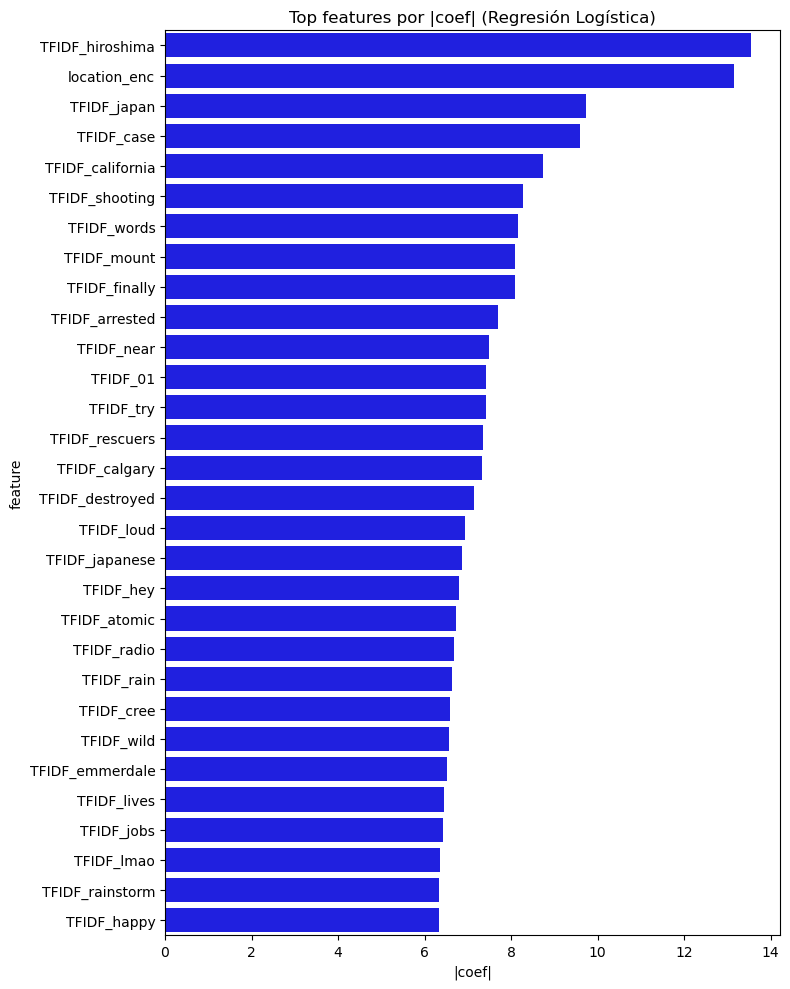

In [31]:
tfidf_col_names = [f"TFIDF_{c}" for c in vectorizer.get_feature_names_out()]
feature_names_tab = num_features + ['location_enc', 'keyword_enc'] + tfidf_col_names
# Coefs del mejor_clf (coef_ corresponde a todas las features incl. embeddings)
coefs = best_clf.coef_[0]
# Tomamos coeficientes relativos a las features tabulares (al inicio)
n_tab = len(feature_names_tab)
tab_coefs = coefs[:n_tab]
imp_df = pd.DataFrame({'feature': feature_names_tab, 'coef_abs': np.abs(tab_coefs), 'coef': tab_coefs})
imp_df = imp_df.sort_values('coef_abs', ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(x='coef_abs', y='feature', data=imp_df, color='b')
plt.title('Top features por |coef| (Regresión Logística)')
plt.xlabel('|coef|')
plt.tight_layout()
plt.show()


## 8) Reentrenar sobre todo el train y predecir test.csv para Kaggle
Si querés enviar predicciones a la competencia, entrenamos el mejor modelo sobre todo el `train.csv`, calculamos embeddings para `test.csv` y guardamos `id,target` en un CSV.

In [ ]:
# Reentrenar preprocessor sobre todo df y embeddings ya calculados
preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_cat)
    ],
    remainder='drop'
)
X_tab_full = df[features_num + features_cat]
X_tab_full_proc = preprocessor_full.fit_transform(X_tab_full)
X_full_final = np.hstack([X_tab_full_proc, embeddings])

# Reentrenar el mejor clasificador con el mejor C sobre todo el set
best_C = grid.best_params_['C']
clf_final = LogisticRegression(C=best_C, max_iter=1000, class_weight='balanced', random_state=SEED)
clf_final.fit(X_full_final, y)

# Guardar modelo y preprocessor
joblib.dump({'preprocessor': preprocessor_full, 'clf': clf_final, 'sbert_model': model_name}, 'baseline_pipeline.joblib')
print('Modelo final guardado en baseline_pipeline.joblib')


In [ ]:
# Si existe test.csv, generar predicciones y guardar CSV para Kaggle
test_path = 'test.csv'
if os.path.exists(test_path):
    df_test = pd.read_csv(test_path)
    df_test['text'] = df_test['text'].fillna('').astype(str)
    df_test['keyword'] = df_test['keyword'].fillna('missing').astype(str)
    df_test['location'] = df_test['location'].fillna('missing').astype(str)
    df_test['text_length'] = df_test['text'].apply(len)
    df_test['word_count'] = df_test['text'].apply(lambda s: len(s.split()))
    df_test['location_simple'] = df_test['location'].str.lower().str.split(',').str[0]
    df_test['keyword'] = df_test['keyword'].str.lower().str.strip()
    # calcular embeddings para test (usamos SBERT cargado antes)
    print('Calculando embeddings SBERT para test...')
    sbert = SentenceTransformer(model_name)
    test_emb = sbert.encode(df_test['text'].tolist(), show_progress_bar=True, batch_size=64, convert_to_numpy=True)
    X_test_tab = df_test[features_num + features_cat]
    X_test_tab_proc = preprocessor_full.transform(X_test_tab)
    X_test_final = np.hstack([X_test_tab_proc, test_emb])
    y_test_pred = clf_final.predict(X_test_final)
    submission = df_test[['id']].copy()
    submission['target'] = y_test_pred
    submission.to_csv('baseline_submission.csv', index=False)
    print('Predicciones guardadas en baseline_submission.csv')
else:
    print('No se encontró test.csv en el directorio. Coloca test.csv si querés generar el CSV de submission.')


---
## Notas finales para el informe
- **¿Cómo conviene obtener el dataset para validar?**: usar validación estratificada (80/20) o CV estratificada (5-fold) para obtener estimaciones estables del F1 debido al desbalance de clases.
- **Mejor score de validación**: aparece como `grid.best_score_` (F1 promedio CV).
- **Score en la competencia**: ejecutar la celda final con `test.csv` y subir `baseline_submission.csv` a Kaggle; el score será el que informe Kaggle en el leaderboard / private leaderboard.
- **Importancia de features**: se grafican los coeficientes absolutos de las features tabulares. Los embeddings son vectores densos; su interpretación directa por dimensión es menos intuitiva y suele requerir técnicas adicionales (SHAP, análisis de pesos, etc.).


In [32]:
test_path = 'data/test.csv'
df = pd.read_csv(test_path)

In [33]:
# Limpieza y preprocesamiento básico de texto
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].apply(clean_text)
df['location'] = df['location'].fillna('no_location_contained')

df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))
df['has_hashtag'] = df['num_hashtags'].apply(lambda x: 1 if x > 0 else 0)
df['has_mention'] = df['num_mentions'].apply(lambda x: 1 if x > 0 else 0)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)

df[['text_len','word_count','mean_word_len','num_hashtags','num_mentions','has_url','disaster_terms_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
text_len,3263.0,70.996322,26.406330,4.000000,52.000000,73.000000,92.000000,122.000000
word_count,3263.0,14.715599,6.191311,1.000000,10.000000,15.000000,19.000000,32.000000
mean_word_len,3263.0,5.022498,1.085340,2.428571,4.285714,4.888889,5.571429,14.333333
num_hashtags,3263.0,0.472878,1.090811,0.000000,0.000000,0.000000,0.000000,12.000000
num_mentions,3263.0,0.392277,0.758739,0.000000,0.000000,0.000000,1.000000,10.000000
has_url,3263.0,0.530493,0.499146,0.000000,0.000000,1.000000,1.000000,1.000000
disaster_terms_count,3263.0,1.369905,0.842707,0.000000,1.000000,1.000000,2.000000,5.000000


In [37]:
num_features = ['text_len', 'word_count', 'mean_word_len',
                'num_hashtags', 'num_mentions', 'disaster_terms_count']
cat_features = ['keyword', 'location', 'has_url',
                'has_hashtag', 'has_mention', 'location_mentioned']
emb_features = ['text_clean']
test = df[num_features + cat_features + emb_features]

In [40]:
test_val_loc_enc = loc_encoding.transform(test[['location']])
test_val_kyw_enc = kyw_encoding.transform(test[['keyword']])
test_val_text_emb = vectorizer.transform(test['text_clean']).toarray()
test_final = np.hstack([test[num_features], test_val_loc_enc, test_val_kyw_enc, test_val_text_emb])
print('test_final shape:', test_final.shape)

test_final shape: (3263, 1008)


In [41]:
test_pred = best_clf.predict(test_final)

In [45]:
submission = pd.DataFrame({'id': df['id'], 'target': test_pred})
submission.to_csv('submission.csv', index=False)